In [1]:
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

from keras.applications import VGG16

In [2]:
base_image_path = "images/pipoca.jpg"
style_reference_image_path = "images/style_pavao.jpg"

original_width, original_height = tf.keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

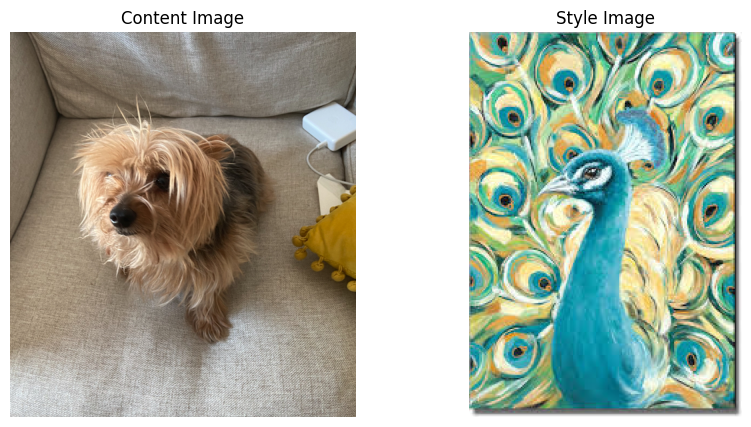

In [3]:
# plot content and style images
plt.figure(figsize=(10, 5))
content = Image.open(base_image_path)
style = Image.open(style_reference_image_path)
plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title("Content Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title("Style Image")
plt.axis("off")
plt.show()

### Define some auxiliary functions to preprocess and deprocess the images

In [4]:
def preprocess_image(image_path, target_size=(img_height, img_width, 3)):
    img = tf.keras.utils.load_img(
        image_path, target_size=target_size)
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img, target_size=(img_height, img_width, 3)):
    # revert the preprocessing by VGG19
    # remove zero-center by mean pixel value of ImageNet.
    img = img.reshape(target_size)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Also, convert back from 'BGR' to 'RGB'.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

### Plot the proprocessed images to check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


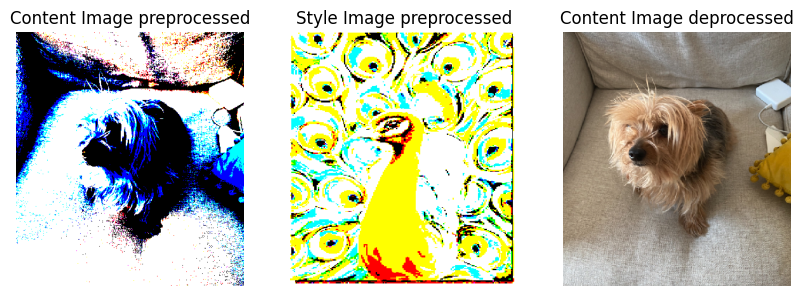

In [5]:
# plot content and style images
plt.figure(figsize=(10, 5))
content = preprocess_image(base_image_path)
style = preprocess_image(style_reference_image_path)
content_deprocessed = deprocess_image(np.copy(content[0]))

plt.subplot(1, 3, 1)
plt.imshow(content[0])
plt.title("Content Image preprocessed")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(style[0])
plt.title("Style Image preprocessed")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(content_deprocessed)
plt.title("Content Image deprocessed")
plt.axis("off")
plt.show()

### Here I define the images for Style transfer

In [6]:
# Notice the images are casted as tensors

base_image = K.constant(preprocess_image(base_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.variable(base_image)

print(base_image.shape, style_reference_image.shape, combination_image.shape)

(1, 400, 359, 3) (1, 400, 359, 3) (1, 400, 359, 3)


---

### Define the base, style and combination images for transfer learning

In [7]:
# define the submodel
submodel = VGG16(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)


# The outputs_dict is important for capturing the activations of intermediate layers
outputs_dict = dict([(layer.name, layer.output) for layer in submodel.layers])

# create a model that returns these outputs given the model input
model = tf.keras.Model(inputs=submodel.inputs, outputs=outputs_dict)
outputs_dict 

{'input_1': <KerasTensor: shape=(None, 400, 359, 3) dtype=float32 (created by layer 'input_1')>,
 'block1_conv1': <KerasTensor: shape=(None, 400, 359, 64) dtype=float32 (created by layer 'block1_conv1')>,
 'block1_conv2': <KerasTensor: shape=(None, 400, 359, 64) dtype=float32 (created by layer 'block1_conv2')>,
 'block1_pool': <KerasTensor: shape=(None, 200, 179, 64) dtype=float32 (created by layer 'block1_pool')>,
 'block2_conv1': <KerasTensor: shape=(None, 200, 179, 128) dtype=float32 (created by layer 'block2_conv1')>,
 'block2_conv2': <KerasTensor: shape=(None, 200, 179, 128) dtype=float32 (created by layer 'block2_conv2')>,
 'block2_pool': <KerasTensor: shape=(None, 100, 89, 128) dtype=float32 (created by layer 'block2_pool')>,
 'block3_conv1': <KerasTensor: shape=(None, 100, 89, 256) dtype=float32 (created by layer 'block3_conv1')>,
 'block3_conv2': <KerasTensor: shape=(None, 100, 89, 256) dtype=float32 (created by layer 'block3_conv2')>,
 'block3_conv3': <KerasTensor: shape=(Non

---

## Define the loss functions

In [8]:
def content_loss(base, generated):
    """ content loss will make sure that the top layer of VGG16 has a
        similar view of the base image
        
        base: the activations of the intermediate layer of the base image
        generated: the activations of the intermediate layer of the generated image
    """
    
    return K.sum(K.square(generated - base))

In [9]:
def gram_matrix(x):
    """ the gram matrix of an image tensor (feature map) is the dot product of the
        reshaped tensor with its transpose"""
    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, generated):
    """ style loss is the sum of the squared differences between the gram matrices of the
        style image and the generated image"""
    
    S = gram_matrix(style)
    G = gram_matrix(generated)
    channels = 3
    size = img_height * img_width
    
    return K.sum(K.square(S - G)) / (4.0 * (channels ** 2) * (size ** 2))

In [10]:
def total_variation_loss(x):
    """ total variation loss is the sum of the squared differences between the pixels of the
        generated image and the pixels of the generated image shifted by one pixel in both
        the horizontal and vertical directions.
        This loss is used to smooth the generated image"""
    
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

In [11]:
def input_tensor_concat(base_image, style_reference_image, combination_image):
    """ This is a helper function to concatenate the base_image, style_reference_image and
        combination_image into a single tensor"""
    
    return K.concatenate(
       [base_image, style_reference_image, combination_image], axis=0
    )

---

### Defining the final loss that you'll minimize

In [12]:
# Define the names of the layers that will be used to compute the loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv3"

# Define the weights in the weighted average for the loss components
# You can play around with these weights to get different results
total_variation_weight = 1e-6
style_weight = 1e-4
content_weight = 1e-8

In [13]:
def compute_loss(base_image, style_reference_image, combination_image):
    """ compute the total loss of the combination image.

        combination_image : the image to be optimized.
        base_image : the image that will be used to compute the content loss.
        style_reference_image : the image that will be used to compute the style loss.
        returns the total loss as a scalar tensor.
    """ 

    input_tensor = input_tensor_concat(base_image, style_reference_image, combination_image)

    # features is a dictionary to capture the activations of the intermediate layers
    features = model(input_tensor) 
    loss =  tf.zeros(shape=()) # loss is a scalar tensor

    # get the activations of the content layer
    layer_features = features[content_layer_name] 
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    # The content loss
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    
    # The style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

---

### Function optimization step

In [14]:
# Define the optimizer and the hyperparameters

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=10.,
    decay_steps=10,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)


In [15]:
@tf.function
def train_step(base_image, style_reference_image, combination_image):
    """ function to be used with tf.GradientTape to compute the gradients of the loss
        with respect to the combination image.
    """
    
    with tf.GradientTape() as tape:
        loss = compute_loss(base_image, style_reference_image, combination_image)
    
    # compute the gradients of the loss with respect to the combination_image
    grads = tape.gradient(loss, combination_image)
    
    # apply the gradients to the combination_image
    optimizer.apply_gradients([(grads, combination_image)])

    return loss, grads

In [16]:
def minimize():
    """ function to minimize the loss by updating the combination image"""

    loss_values = []
    grad_values = []
    iterations = 50
    for i in range(1, iterations+1):
        loss, grads = train_step(base_image, style_reference_image, combination_image)
        loss_values.append(loss)
        grad_values.append(grads)
    
        if i % 10 == 0:
            print("Iteration %d: loss=%.2f" % (i, loss))

    # deprocess the image, save it, and plot it
    img = deprocess_image(combination_image.numpy())
    # fname = "combination_image_at_%d.png" % i
    # tf.keras.utils.save_img(fname, img)
    # print("Image saved as", fname)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("New Content Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(deprocess_image(style[0]))
    plt.title("Style Image")
    plt.axis("off")
    plt.show()

    return [loss_values, grad_values]

Iteration 10: loss=683674.19
Iteration 20: loss=228267.22
Iteration 30: loss=164407.69
Iteration 40: loss=136449.92
Iteration 50: loss=118974.65


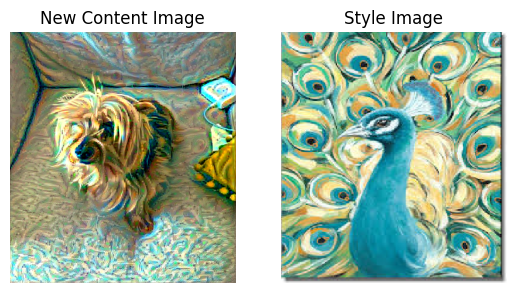

Time taken: 0:01:10.738373
CPU times: user 8min 17s, sys: 27.5 s, total: 8min 44s
Wall time: 1min 10s


In [17]:
%%time
start_datetime = datetime.now()

loss_grads_values = minimize()

end_datetime = datetime.now()
print("Time taken:", end_datetime - start_datetime)

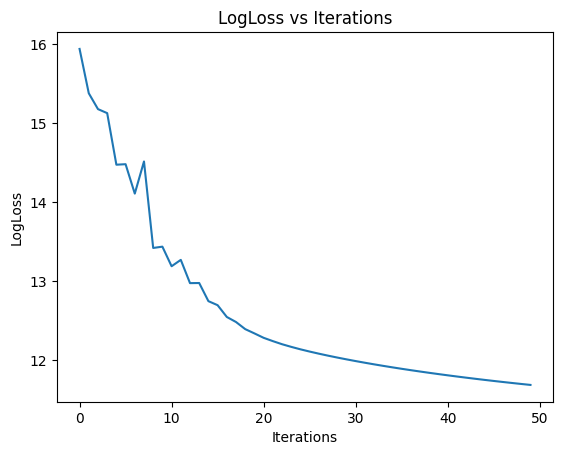

In [18]:
# plot the loss values in log scale

log_loss = [np.log(x) for x in loss_grads_values[0]]
plt.plot(log_loss)
plt.xlabel("Iterations")
plt.ylabel("LogLoss")
plt.title("LogLoss vs Iterations")
plt.show()